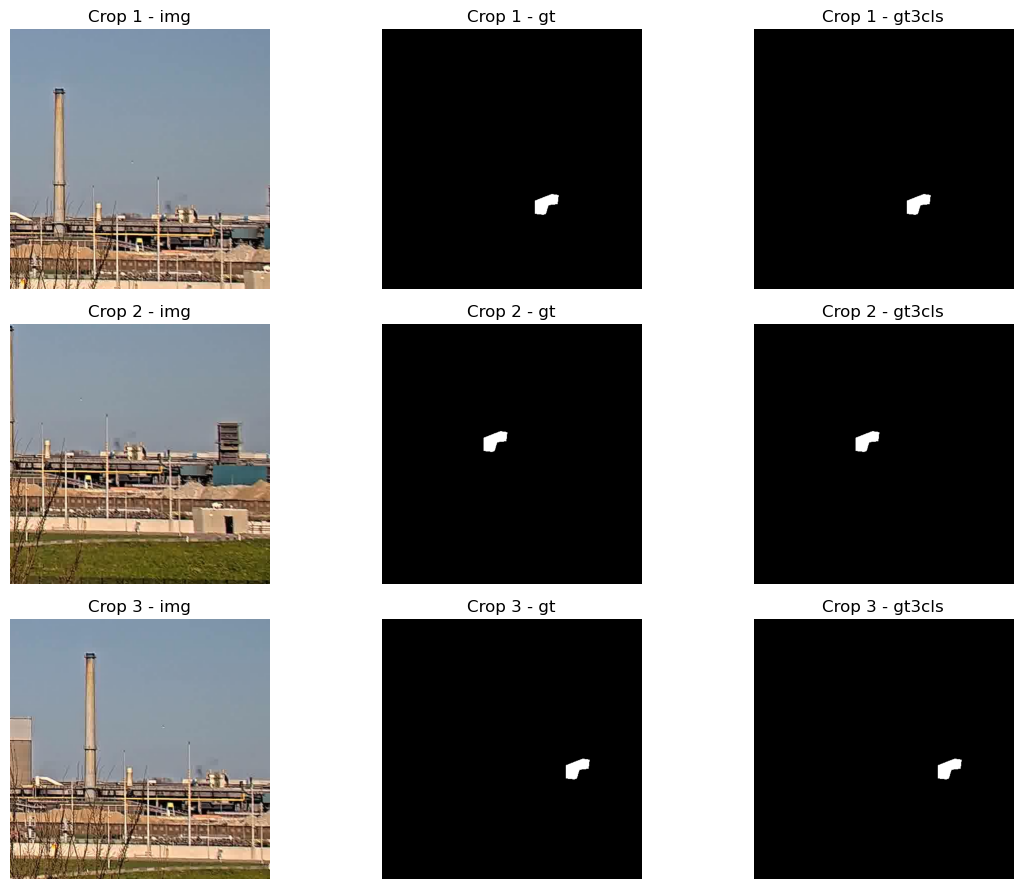

In [80]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

# 裁剪函数，保证img、gt、gt_3cls偏移量一致
def crop_all_regions_multi(img, masks, crop_size=600, n_random=3, max_offset_ratio=0.4):
    # masks: list of mask (如 [gt, gt3cls])
    H, W = masks[0].shape
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(masks[0].astype(np.uint8), connectivity=8)
    half = crop_size // 2
    crops_img, crops_masks = [], [[] for _ in masks]
    for label in range(1, num_labels):
        x_min, y_min, w, h, area = stats[label]
        cx, cy = centroids[label].astype(int)
        x_max, y_max = x_min + w, y_min + h
        for _ in range(n_random):
            max_dx = int(crop_size * max_offset_ratio)
            max_dy = int(crop_size * max_offset_ratio)
            dx = random.randint(-max_dx, max_dx)
            dy = random.randint(-max_dy, max_dy)
            x0 = cx - half + dx
            y0 = cy - half + dy
            if x0 > x_min: x0 = x_min
            if x0 + crop_size < x_max: x0 = x_max - crop_size
            if y0 > y_min: y0 = y_min
            if y0 + crop_size < y_max: y0 = y_max - crop_size
            x0 = max(0, min(x0, W - crop_size))
            y0 = max(0, min(y0, H - crop_size))
            crops_img.append(img[y0:y0+crop_size, x0:x0+crop_size].copy())
            for i, m in enumerate(masks):
                crops_masks[i].append(m[y0:y0+crop_size, x0:x0+crop_size].copy())
    return crops_img, crops_masks

# 数据路径
base_dir = '../data/ijmond_data/test_raw/'
img_dir = os.path.join(base_dir, 'img')
gt_dir = os.path.join(base_dir, 'gt')
gt3cls_dir = os.path.join(base_dir, 'gt_3cls')

# 检查目录是否存在
for d in [img_dir, gt_dir, gt3cls_dir]:
    if not os.path.isdir(d):
        raise FileNotFoundError(f"目录不存在: {d}")

# 只保留图片文件
def filter_images(file_list):
    exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')
    return [f for f in file_list if f.lower().endswith(exts)]

img_files = filter_images(sorted(os.listdir(img_dir)))
gt_files = filter_images(sorted(os.listdir(gt_dir)))
gt3cls_files = filter_images(sorted(os.listdir(gt3cls_dir)))

if not img_files:
    raise FileNotFoundError(f"目录 {img_dir} 下没有图片文件")
if not gt_files:
    raise FileNotFoundError(f"目录 {gt_dir} 下没有图片文件")
if not gt3cls_files:
    raise FileNotFoundError(f"目录 {gt3cls_dir} 下没有图片文件")

img_path = os.path.join(img_dir, img_files[0])
gt_path = os.path.join(gt_dir, gt_files[0])
gt3cls_path = os.path.join(gt3cls_dir, gt3cls_files[0])

# 检查图片文件是否存在
for p in [img_path, gt_path, gt3cls_path]:
    if not os.path.isfile(p):
        raise FileNotFoundError(f"文件不存在: {p}")

# 读取图片
img = cv2.imread(img_path)
if img is None:
    raise ValueError(f"无法读取图片: {img_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gt = cv2.imread(gt_path, 0)
if gt is None:
    raise ValueError(f"无法读取图片: {gt_path}")
gt3cls = cv2.imread(gt3cls_path, 0)
if gt3cls is None:
    raise ValueError(f"无法读取图片: {gt3cls_path}")

# 裁剪（偏移量统一）
crops_img, [crops_gt, crops_gt3cls] = crop_all_regions_multi(img, [gt, gt3cls], crop_size=512)

# 可视化前4个裁剪结果（含gt3cls）
n = min(4, len(crops_img), len(crops_gt), len(crops_gt3cls))
plt.figure(figsize=(12, 3*n))
for i in range(n):
    plt.subplot(n, 3, 3*i+1)
    plt.imshow(crops_img[i])
    plt.title(f'Crop {i+1} - img')
    plt.axis('off')
    plt.subplot(n, 3, 3*i+2)
    plt.imshow(crops_gt[i], cmap='gray')
    plt.title(f'Crop {i+1} - gt')
    plt.axis('off')
    plt.subplot(n, 3, 3*i+3)
    plt.imshow(crops_gt3cls[i], cmap='gray')
    plt.title(f'Crop {i+1} - gt3cls')
    plt.axis('off')
plt.tight_layout()
plt.show()

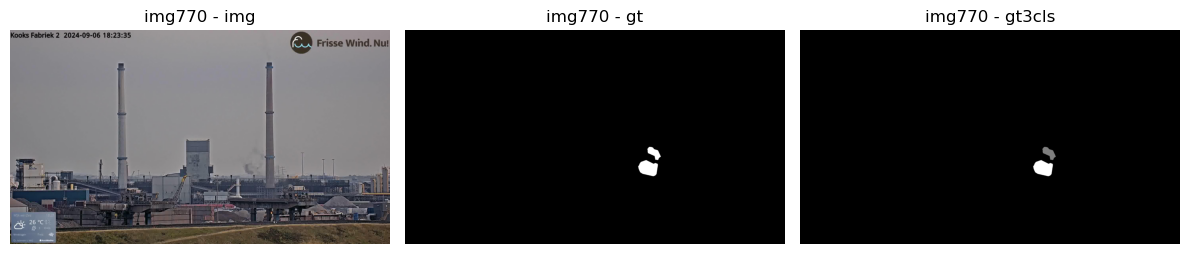

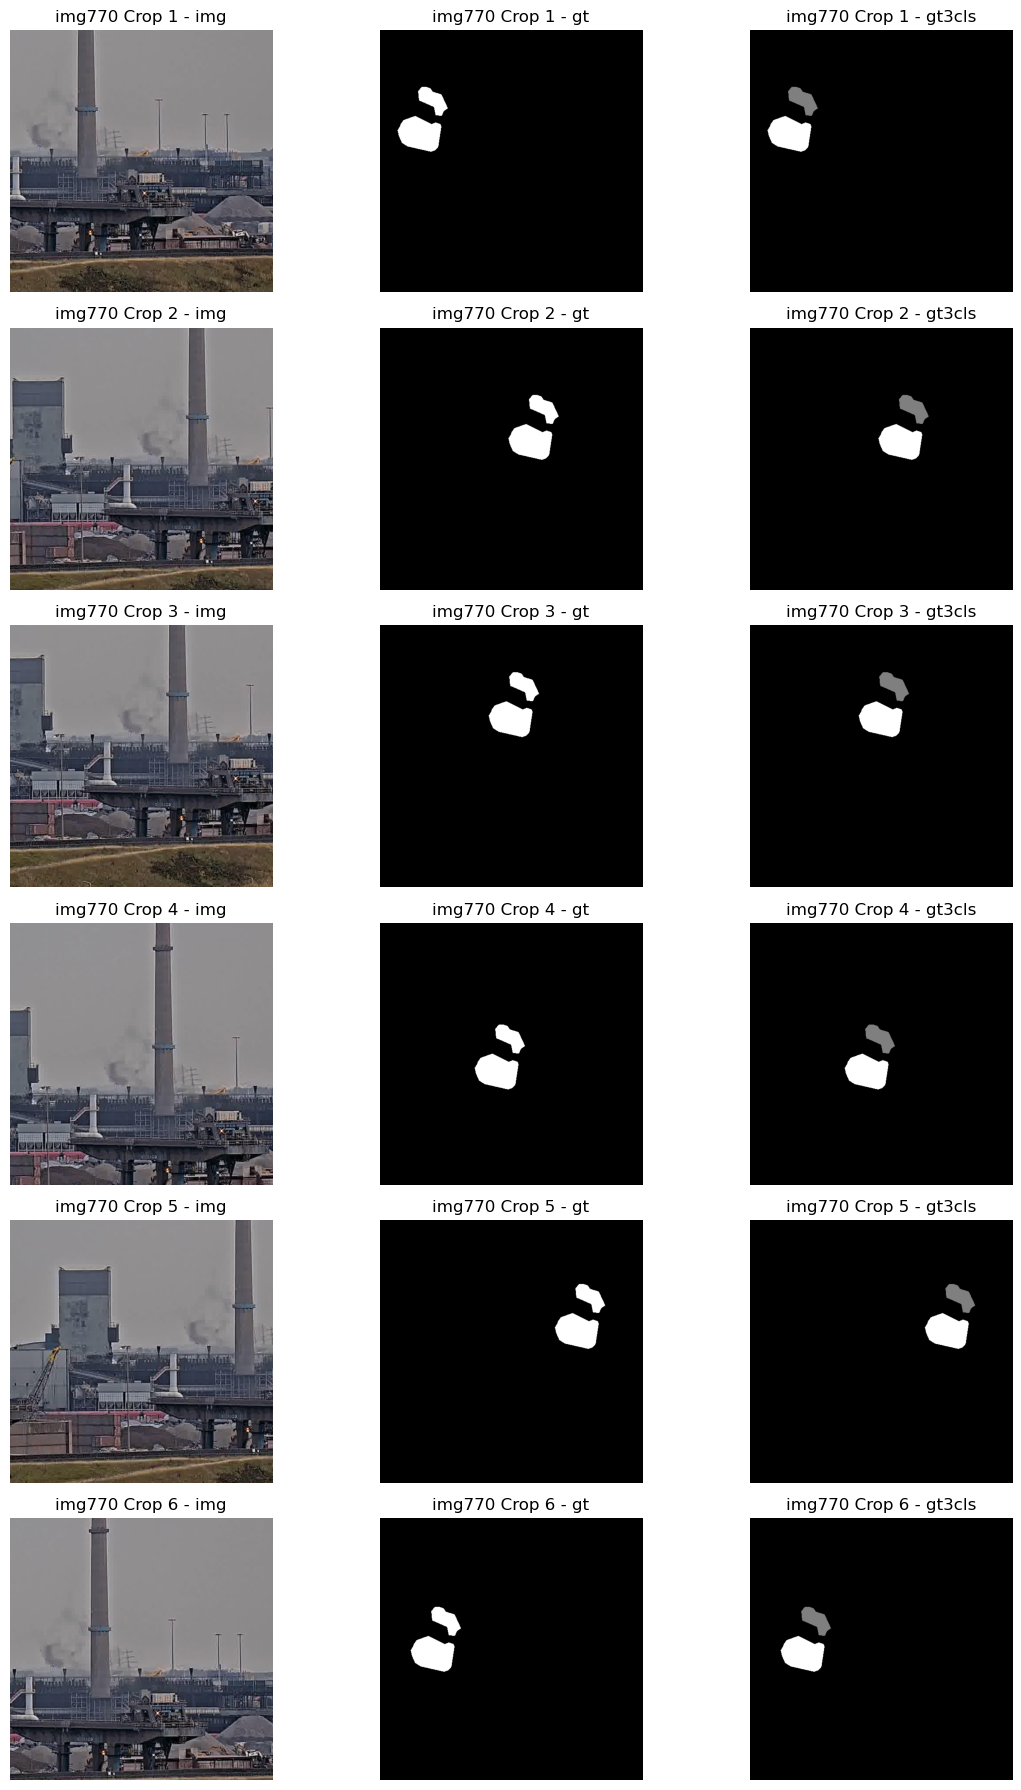

In [81]:
# 可视化 data/ijmond_data/test/ 下 NAME 的 img、gt、gt_3cls，并对三者切片可视化

NAME = 'img770'  # 只需修改此变量即可切换目标图片

def find_file_with_stem(directory, stem):
    for f in os.listdir(directory):
        if os.path.splitext(f)[0] == stem:
            return os.path.join(directory, f)
    raise FileNotFoundError(f"{directory} 下未找到主名为 {stem} 的文件")

img_path = find_file_with_stem(img_dir, NAME)
gt_path = find_file_with_stem(gt_dir, NAME)
gt3cls_path = find_file_with_stem(gt3cls_dir, NAME)

for p in [img_path, gt_path, gt3cls_path]:
    if not os.path.isfile(p):
        raise FileNotFoundError(f"文件不存在: {p}")

img = cv2.imread(img_path)
if img is None:
    raise ValueError(f"无法读取图片: {img_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gt = cv2.imread(gt_path, 0)
if gt is None:
    raise ValueError(f"无法读取图片: {gt_path}")
gt3cls = cv2.imread(gt3cls_path, 0)
if gt3cls is None:
    raise ValueError(f"无法读取图片: {gt3cls_path}")

# 整图可视化
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title(f'{NAME} - img')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(gt, cmap='gray')
plt.title(f'{NAME} - gt')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(gt3cls, cmap='gray')
plt.title(f'{NAME} - gt3cls')
plt.axis('off')
plt.tight_layout()
plt.show()

# 切片可视化，偏移量统一
crops_img, [crops_gt, crops_gt3cls] = crop_all_regions_multi(img, [gt, gt3cls], crop_size=600)
n = min(len(crops_img), len(crops_gt), len(crops_gt3cls))
plt.figure(figsize=(12, 3*n))
for i in range(n):
    plt.subplot(n, 3, 3*i+1)
    plt.imshow(crops_img[i])
    plt.title(f'{NAME} Crop {i+1} - img')
    plt.axis('off')
    plt.subplot(n, 3, 3*i+2)
    plt.imshow(crops_gt[i], cmap='gray')
    plt.title(f'{NAME} Crop {i+1} - gt')
    plt.axis('off')
    plt.subplot(n, 3, 3*i+3)
    plt.imshow(crops_gt3cls[i], cmap='gray')
    plt.title(f'{NAME} Crop {i+1} - gt3cls')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [82]:
import os
import cv2
import numpy as np
import random

# 输入输出路径
data_root = '../data/ijmond_data/test_raw'
out_root = '../data/ijmond_data/test'
folders = ['img', 'gt', 'gt_3cls']
crop_size = 600  # 可根据需要调整
n_random_crops = 2  # 每个连通域裁剪次数

def filter_images(file_list):
    exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')
    return [f for f in file_list if os.path.splitext(f)[1].lower() in exts]

os.makedirs(out_root, exist_ok=True)
for folder in folders:
    os.makedirs(os.path.join(out_root, folder), exist_ok=True)

def get_common_stems(*folders):
    sets = [set(os.path.splitext(f)[0] for f in filter_images(os.listdir(folder))) for folder in folders]
    return set.intersection(*sets)

img_dir = os.path.join(data_root, 'img')
gt_dir = os.path.join(data_root, 'gt')
gt3cls_dir = os.path.join(data_root, 'gt_3cls')
out_img_dir = os.path.join(out_root, 'img')
out_gt_dir = os.path.join(out_root, 'gt')
out_gt3cls_dir = os.path.join(out_root, 'gt_3cls')

common_stems = get_common_stems(img_dir, gt_dir, gt3cls_dir)
print(f"共找到{len(common_stems)}组同名图片")
for stem in sorted(common_stems):
    def find_file_with_stem(folder, stem):
        for f in os.listdir(folder):
            if os.path.splitext(f)[0] == stem:
                return f
        return None
    img_file = find_file_with_stem(img_dir, stem)
    gt_file = find_file_with_stem(gt_dir, stem)
    gt3cls_file = find_file_with_stem(gt3cls_dir, stem)
    if not (img_file and gt_file and gt3cls_file):
        print(f"跳过: {stem}，有文件缺失")
        continue
    img_path = os.path.join(img_dir, img_file)
    gt_path = os.path.join(gt_dir, gt_file)
    gt3cls_path = os.path.join(gt3cls_dir, gt3cls_file)
    img = cv2.imread(img_path)
    gt = cv2.imread(gt_path, 0)
    gt3cls = cv2.imread(gt3cls_path, 0)
    if img is None or gt is None or gt3cls is None:
        print(f"跳过: {stem}，有图片无法读取")
        continue
    crops_img, [crops_gt, crops_gt3cls] = crop_all_regions_multi(img, [gt, gt3cls], crop_size, n_random=n_random_crops)
    for i, (ci, cg, cg3) in enumerate(zip(crops_img, crops_gt, crops_gt3cls)):
        ext = os.path.splitext(img_file)[1]
        cv2.imwrite(os.path.join(out_img_dir, f'{stem}_crop{i+1}{ext}'), ci)
        ext_gt = os.path.splitext(gt_file)[1]
        cv2.imwrite(os.path.join(out_gt_dir, f'{stem}_crop{i+1}{ext_gt}'), cg)
        ext_gt3cls = os.path.splitext(gt3cls_file)[1]
        cv2.imwrite(os.path.join(out_gt3cls_dir, f'{stem}_crop{i+1}{ext_gt3cls}'), cg3)
    # 随机负样本：不要求mask为0，img/gt/gt3cls区域一致
    H, W = gt.shape
    x0 = random.randint(0, W - crop_size)
    y0 = random.randint(0, H - crop_size)
    patch_img = img[y0:y0+crop_size, x0:x0+crop_size]
    patch_gt = gt[y0:y0+crop_size, x0:x0+crop_size]
    patch_gt3cls = gt3cls[y0:y0+crop_size, x0:x0+crop_size]
    ext = os.path.splitext(img_file)[1]
    ext_gt = os.path.splitext(gt_file)[1]
    ext_gt3cls = os.path.splitext(gt3cls_file)[1]
    cv2.imwrite(os.path.join(out_img_dir, f'{stem}_neg1{ext}'), patch_img)
    cv2.imwrite(os.path.join(out_gt_dir, f'{stem}_neg1{ext_gt}'), patch_gt)
    cv2.imwrite(os.path.join(out_gt3cls_dir, f'{stem}_neg1{ext_gt3cls}'), patch_gt3cls)
    print(f"{stem} 随机负样本已保存")
    print(f"已裁剪并保存: {stem}")
print('全部完成')

共找到800组同名图片
img10 随机负样本已保存
已裁剪并保存: img10
img100 随机负样本已保存
已裁剪并保存: img100


img101 随机负样本已保存
已裁剪并保存: img101
img102 随机负样本已保存
已裁剪并保存: img102
img103 随机负样本已保存
已裁剪并保存: img103
img104 随机负样本已保存
已裁剪并保存: img104
img103 随机负样本已保存
已裁剪并保存: img103
img104 随机负样本已保存
已裁剪并保存: img104
img105 随机负样本已保存
已裁剪并保存: img105
img106 随机负样本已保存
已裁剪并保存: img106
img105 随机负样本已保存
已裁剪并保存: img105
img106 随机负样本已保存
已裁剪并保存: img106
img107 随机负样本已保存
已裁剪并保存: img107
img108 随机负样本已保存
已裁剪并保存: img108
img107 随机负样本已保存
已裁剪并保存: img107
img108 随机负样本已保存
已裁剪并保存: img108
img11 随机负样本已保存
已裁剪并保存: img11
img110 随机负样本已保存
已裁剪并保存: img110
img11 随机负样本已保存
已裁剪并保存: img11
img110 随机负样本已保存
已裁剪并保存: img110
img111 随机负样本已保存
已裁剪并保存: img111
img113 随机负样本已保存
已裁剪并保存: img113
img114 随机负样本已保存
已裁剪并保存: img114
img111 随机负样本已保存
已裁剪并保存: img111
img113 随机负样本已保存
已裁剪并保存: img113
img114 随机负样本已保存
已裁剪并保存: img114
img115 随机负样本已保存
已裁剪并保存: img115
img118 随机负样本已保存
已裁剪并保存: img118
img119 随机负样本已保存
已裁剪并保存: img119
img115 随机负样本已保存
已裁剪并保存: img115
img118 随机负样本已保存
已裁剪并保存: img118
img119 随机负样本已保存
已裁剪并保存: img119
img12 随机负样本已保存
已裁剪并保存: img12
img120 随机负样本已保存
已裁剪并保存: img120
img121 随机负样本已保